# TWO WAY DESIGN (2WD)

This lecture continues the analysis of the Wolf model of glycolytic oscillations to consider the effects of two parameters in combination.

A two way design (2WD) is used to identify interactions between factors.
This means that there is an experiment for every combination of levels of both factors.
That is, there are $n_1 \times n_2$ experiments if there are $n_i$ levels of the two factors.

## Challenges

1. **Combinatorics.**
The Wolf model has 16 parameters, which means that there are 120 interactions, each of which need to be calculated at several levels.
With 10 levels for each interaction, this results in $10 \times 10 \times 120 = 12,000$ constants to calculate.
1. **Visualization.**
How should we present the responses that clearly presents which interaction terms are displayed, their values, and patterns in the responses?
1. **Generalizing 1WD codes for 2WD**. ``runExperiments`` and other codes assumed a 1-way interaction.

# Preliminaries

In [1]:
IS_COLAB = False

In [2]:
# Code installs. Only needed once.
if IS_COLAB:
    !pip install tellurium

In [3]:
# Constants for standalone notebook
if not IS_COLAB:
    DIR = "/home/ubuntu/advancing-biomedical-models/common"  # Insert your local directory path
else:
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = "/content/drive/MyDrive/Modeling_Class_2021/Common"
import sys
sys.path.insert(0, DIR)

## Imports

In [51]:
import util_doe1 as doe1

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te
import seaborn as sns
import util_doe1  # Various functions from lecture 5
import wolf_model as wm

## Constants

In [5]:
WOLF_FACTORS = [
  "J0_inputFlux", "J1_k1", "J1_Ki", "J1_n", "J2_k", "J3_k", "J4_kg", "J4_kp",
 "J4_ka", "J4_kk", "J5_k", "J6_k", "J7_k", "J8_k1", "J8_k2", "J9_k", "J10_k",     
]

# Generalize runExperiments
Generalize ``runExperiments`` so that it calculates responses for all combinations of levels of two factors.

In [49]:
def runExperiments2WD(factor1, factor2, percent1s, percent2s, isRelative=True):
    """
    Runs experiments for multiple factors at different percent changes in factor levels.
    
    Parameter
    ---------
    factor1: str
    factor2: str
    percent1s: list-int
    percent2s: list-int
    isRelative: bool
        True: values are percent changes relative to baseline
        False: absolute value
        
    Returns
    -------
    frequencyDF: DataFrame; amplitude: DataFrame
       index: tuple of percent changes in factor values
       columns: molecule
       value: depends on isRelative
       index.name: string of tuple (rowFactor, columnFactor)
    """
    # Constants
    INDEX1 = "index1"
    INDEX2 = "index2"
    def appendSer(ser, baseSer, sers):
        adjSer = 100*(ser - baseSer) / baseSer
        sers.append(pd.DataFrame(adjSer).transpose())
    def calcResult(sers):
        resultDF = pd.concat(sers)
        resultDF[INDEX1] = index1
        resultDF[INDEX2] = index2
        resultDF = resultDF.set_index([index1, index2])
        for column in [INDEX1, INDEX2]:
            del resultDF[column]
        resultDF.index.name = str((factor1, factor2))
        return resultDF
    # Initializations
    index1 = []
    index2 = []
    frequencySers = []  # Collection of experiment results
    amplitudeSers = []
    baseFrequencySer, baseAmplitudeSer = util_doe1.runExperiment({})
    # Calculate the changes
    for percent1 in percent1s:
        for percent2 in percent2s:
            #indices.append("%d_%d" % (percent1, percent2))
            index1.append(percent1)
            index2.append(percent2)
            factorDct = {factor1: percent1, factor2: percent2}
            frequencySer, amplitudeSer = util_doe1.runExperiment(factorDct)
            appendSer(frequencySer, baseFrequencySer, frequencySers)
            appendSer(amplitudeSer, baseAmplitudeSer, amplitudeSers)
    # Construct the result dataframe
    frequencyDF = calcResult(frequencySers)
    amplitudeDF = calcResult(amplitudeSers)
    return frequencyDF, amplitudeDF

# Tests
percents = [-7, -5, -2, 0, 2, 5, 7]
fDF, aDF = runExperiments2WD("J1_Ki", "J1_k1", percents, percents)
assert(aDF.loc[(percents[-1], percents[-1]), "Glucose"] < 0 )
assert(fDF.loc[(percents[0], percents[0]), "Glucose"] < 0 )

**Data: Response2WDDF**. We will describe the response for a 2WD using a dataframe structured as above.
* Columns: names of factors
* index.name: str(str, str) - factors changed
* Index: (int, int) (in same order as index)
* Values: float (percent change)

In [9]:
# Test Data
TEST_FDF = fDF
TEST_ADF = aDF

## Question
1. Display the amplitude response if there is no change in either J1_Ki or J1_k1.
1. Display the amplitude responses for J1_Ki is 0% and all changes in J1_k1.

## Solution

In [10]:
# Solution 1
print("** Solution to 1:\n")
print(aDF.loc[(0,0), :])

# Solution 2
indices = [(0, p) for p in percents]
print("\n\n** Solution to 2:\n")
print(aDF.loc[indices, :])

** Solution to 1:

Glucose                       2386.822657
fructose_1_6_bisphosphate     2265.914415
glyceraldehyde_3_phosphate     167.369127
glycerate_3_phosphate         1530.737500
pyruvate                      1416.543784
Acetyladehyde                  -35.791478
External_acetaldehyde          -47.155942
ATP                           2206.509872
ADP                           2206.509872
NAD                             55.428168
NADH                            55.428168
Name: (0, 0), dtype: float64


** Solution to 2:

          Glucose  fructose_1_6_bisphosphate  glyceraldehyde_3_phosphate  \
0 -7  2488.662091                2359.838215                  183.378603   
  -5  1984.101157                1882.752398                  122.251144   
  -2  2133.964933                2006.652169                  139.810325   
   0  2386.822657                2265.914415                  167.369127   
   2  2349.744503                2253.877133                  159.429874   
   5  1776.76

# Visualizing results of an Experiment

We will visualize the TFC reponses using a heatmap. The horizontal and vertical axes
will be percent changes in parameter values; cells will be colored with the change in magnitude.

## Question 1
1. Generate a heatmap for the results of experiments varying the parameters "J1_k1" and "J1_Ki" in combination
for levels -10, -5, 0, 5, 10.
The names of molecules should be the rows.

## Solution 1

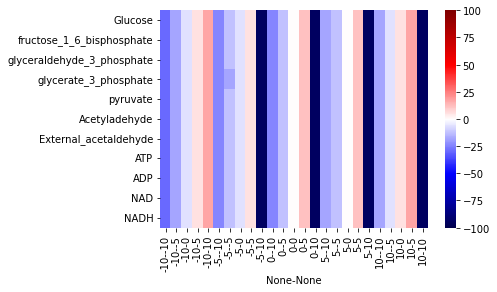

In [46]:
percents = [-10, -5, 0, 5, 10]
fDF, _ = runExperimentsTwoFactors("J1_k1", "J1_Ki", percents, percents)
_ = sns.heatmap(fDF.transpose(), cmap='seismic', vmin=-100, vmax=100)

**Simulate Wolf model at different changes**

In [52]:
# Baseline
doe1.runSimulation({})

         time, [Glucose], [fructose_1_6_bisphosphate], [glyceraldehyde_3_phosphate], [glycerate_3_phosphate], [pyruvate], [Acetyladehyde], [External_acetaldehyde],      [ATP],    [ADP],    [NAD],   [NADH]
 [[         0,         0,                           0,                            0,                       0,          0,               0,                       0,          3,        1,      0.5,      0.5],
  [ 0.0167224,  0.404346,                    0.415475,                    0.0195397,               0.0059478, 0.00388141,     2.39256e-05,             1.07795e-05,    1.11533,  2.88467, 0.493268, 0.506732],
  [ 0.0334448,  0.634215,                     0.89217,                    0.0917956,               0.0328687,   0.107254,      0.00074881,             0.000502235,  0.0324592,  3.96754, 0.411064, 0.588936],
  [ 0.0501672,   1.28222,                    0.930789,                     0.111984,               0.0349168,   0.261133,      0.00177251,              0.00135845,  0.0158095

In [ ]:
parameterDct = {"J1_k1": -10, "J1_Ki": -10}
doe1.runSimulation(parameterDct)

In [47]:
fDF

Glucose  fructose_1_6_bisphosphate  glyceraldehyde_3_phosphate  \
-10 -10 -29.411765                 -29.411765                  -29.411765   
    -5  -17.647059                 -17.647059                  -17.647059   
     0   -5.882353                  -5.882353                   -5.882353   
     5    5.882353                   5.882353                    5.882353   
     10  17.647059                  17.647059                   17.647059   
-5  -10 -23.529412                 -23.529412                  -23.529412   
    -5  -11.764706                 -11.764706                  -11.764706   
     0   -5.882353                  -5.882353                   -5.882353   
     5    5.882353                   5.882353                    5.882353   
     10 -94.117647                 -94.117647                  -94.117647   
 0  -10 -23.529412                 -23.529412                  -23.529412   
    -5  -11.764706                 -11.764706                  -11.764706   
     0    0.000000                   0.000000                    0.000000   
     5   11.764706                  11.764706                   11.764706   
     10 -94.117647                 -94.117647                  -94.117647   
 5  -10 -17.647059                 -17.647059                  -17.647059   
    -5  -11.764706                 -11.764706                  -11.764706   
     0    0.000000                   0.000000                    0.000000   
     5   11.764706                  11.764706                   11.764706   
     10 -94.117647                 -94.117647                  -94.117647   
 10 -10 -17.647059                 -17.647059                  -17.647059   
    -5   -5.882353                  -5.882353                   -5.882353   
     0    5.882353                   5.882353                    5.882353   
     5   17.647059                  17.647059                   17.647059   
     10 -94.117647                 -94.117647                  -94.117647   

         glycerate_3_phosphate   pyruvate  Acetyladehyde  \
-10 -10             -29.411765 -29.411765     -29.411765   
    -5              -17.647059 -17.647059     -17.647059   
     0               -5.882353  -5.882353      -5.882353   
     5                5.882353   5.882353       5.882353   
     10              17.647059  17.647059      17.647059   
-5  -10             -23.529412 -23.529412     -23.529412   
    -5              -17.647059 -11.764706     -11.764706   
     0               -5.882353  -5.882353      -5.882353   
     5                5.882353   5.882353       5.882353   
     10             -94.117647 -94.117647     -94.117647   
 0  -10             -23.529412 -23.529412     -23.529412   
    -5              -11.764706 -11.764706     -11.764706   
     0                0.000000   0.000000       0.000000   
     5               11.764706  11.764706      11.764706   
     10             -94.117647 -94.117647     -94.117647   
 5  -10             -17.647059 -17.647059     -17.647059   
    -5              -11.764706 -11.764706     -11.764706   
     0                0.000000   0.000000       0.000000   
     5               11.764706  11.764706      11.764706   
     10             -94.117647 -94.117647     -94.117647   
 10 -10             -17.647059 -17.647059     -17.647059   
    -5               -5.882353  -5.882353      -5.882353   
     0                5.882353   5.882353       5.882353   
     5               17.647059  17.647059      17.647059   
     10             -94.117647 -94.117647     -94.117647   

         External_acetaldehyde        ATP        ADP        NAD       NADH  
-10 -10             -29.411765 -29.411765 -29.411765 -29.411765 -29.411765  
    -5              -17.647059 -17.647059 -17.647059 -17.647059 -17.647059  
     0               -5.882353  -5.882353  -5.882353  -5.882353  -5.882353  
     5                5.882353   5.882353   5.882353   5.882353   5.882353  
     10              17.647059  17.647059  17.647059  17.64705

Interpret this result.

In [12]:
def pivotResponse(responseDF, molecule):
    """
    Creates a DataFrame in which values of the parameters are rows and columns.
    
    Parameters
    ----------
    responseDF: DataFrame
        columns: molecule names
        rows: tuple of percent changes in parameters
        values: response
        index.name: string of tuple (rowParameter, columnParameter)
    molecule: str
        
    Returns
    -------
    DataFrame
        columns: values of columnParameter
        rows: values of rowParameter
        cells: response for molecule
    """
    LEVEL0 = "level_0"
    LEVEL1 = "level_1"
    df = responseDF.reset_index()
    resultDF = pd.pivot_table(df, values=molecule, index=LEVEL0, columns=LEVEL1)
    parameters = eval(responseDF.index.name)
    resultDF.index.name = parameters[0]
    resultDF.columns.name = parameters[1]
    return resultDF

# Tests
df = pivotResponse(TEST_FDF, "Glucose")
#pd.pivot_table(df, values="Glucose", index="level_0", columns="level_1")
assert(len(df.index) == len(df.columns))

## Question 2
1. Write a function that constructs a heatmap that displays interaction results for a single molecule (e.g., Glucose) and has rows that are changes to one parameter and columns that are changes to the other parameter. The function should return the axis.

## Solution 2

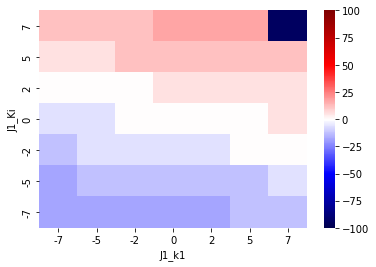

In [13]:
def makeHeatmap(responseDF, molecule, isColorbar=True, ax=None, vmin=-100, vmax=100, cbar_ax=None):
    """
    Creates a heatmap showing the interactions of response values for two parameters.
    
    Parameters
    ----------
    reponseDF: DataFrame
        index: tuples of percent changes in parameter values
        columns: molecule
        values: response
    molecule: str
    isColorbar: bool
        show the colorbar
    vmin: float
        minimum value in color bar
    vmax: float
        maximum value in color bar
    cbar_ax: Axes
    """
    df = pivotResponse(responseDF, molecule)
    df = df.sort_index(ascending=False)  # Show large values on top
    if ax is None:
        ax = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, cbar_ax=cbar_ax)
    else:
        _ = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, ax=ax, cbar_ax=cbar_ax)
    return ax

# Tests
_ = makeHeatmap(TEST_FDF, "ATP")

# Calculating DOE Parameters

For 2WD, we must calculate $\mu, \alpha_{i, k_i}, \alpha_{i, k_i, j, k_j}$.
1. Use 1WD to obtain $\mu, \alpha_{i, k_i}$
1. Calculate $y_{i, k_i, j, k_j}$ responses
1. Calculate $\alpha_{i, k_i, j, k_j}$: $\alpha_{i, k_i, j, k_j} = y_{i, k_i, j, k_j} - \mu
- \alpha_{i, k_i} - \alpha_{j, k_j}$

## Extracting 1WD information from a 2WD experiment

A 2WD experiment contains information from two 1WD experiments.
The function ``calc1WDParameters`` calculates $\mu$, $\alpha_{i, k_i}$, $\alpha_{j, k_j}$.

In [40]:
def calc1WDParameters(response2WDDF):
    """
    Constructs a 1WD response for a single molecule from the results for a 2WD experiment.
    
    Parameters
    ----------
    response2WDDF: DataFrame (Response2WDDF)
    factor: str
    molecule: str
    
    Returns
    -------
    Series: mu
    DataFrame: response for first factor
        index: int (percent change)
        value: float (percent change)
    DataFrame: response for second factor
        index: int (percent change)
        value: float (percent change)  
    """
    def calcFactorSer(pos):
        """
        Calculates the Series for a factor.
        
        Parameters
        ----------
        pos: int
            in the set {0, 1}
          
        Returns
        -------
        DataFrame
        """
        # Find the levels
        levels = list(set([i[pos] for i in response2WDDF.index]))
        levels.sort()
        # Find the indices that determine the 1WD responses
        indices = [(i, 0) for i in levels]
        if pos == 1:
            indices = [(j, i) for i,j in indices]
        #
        df = response2WDDF.loc[indices]
        newIndices = [i[pos] for i in df.index]
        df.index = newIndices
        return df
    # 
    mu = response2WDDF.loc[(0, 0), :]
    alphaiDF = calcFactorSer(0) - mu
    alphajDF = calcFactorSer(1) - mu
    #
    return mu, alphaiDF, alphajDF

# TESTS
muSer, df1, df2 = calc1WDParameters(fDF)
assert(all([m == 0 for m in muSer]))
for df in [df1, df2]:
    assert(isinstance(df, pd.DataFrame))
    assert(len(df) == 5)

## Calculating $\alpha_{i, k_i, j, k_j}$

In [42]:
def calc2WDParameters(response2WDDF):
    """
    Calculates the design of experiment parameters for a 2-Way Design.
    Assumes that there is a level of 0.

    Parameters
    ----------
    DataFrame
       index: tuple of percent changes in factor values
       columns: molecule
       value: float (response)
       index.name: string of tuple (rowFactor, columnFactor)
    
    Returns
    -------
    Series: mu values for factors
    pd.DataFrame: alpha_i,k_i
        column: molecule
        index: factor i levels
        value: float
    pd.DataFrame: alpha_j,k_j
        column: molecule
        index: factor j levels
        value: float
    pd.DataFrame: alpha_i,k_i,j,k_j
        column: molecule
        index: factor i, factor j levels
        value: float
    """
    mu, alphaiDF, alphajDF = calc1WDParameters(response2WDDF)
    alphaijDF = response2WDDF - mu
    # Adjust for alpha_i_ki and alpha_j_kj
    for idx, row in alphaijDF.iterrows():
        iLevel, jLevel = idx
        alphaijDF.loc[idx, :] = alphaijDF.loc[idx, :].values - alphaiDF.loc[iLevel, :].values  \
            - alphajDF.loc[jLevel, :].values
    #
    return mu, alphaiDF, alphajDF, alphaijDF

# TESTS
muSer, alphaiDF, alphajDF, alphaijDF = calc2WDParameters(fDF)
assert(isinstance(muSer, pd.Series))
assert(isinstance(alphaiDF, pd.DataFrame))
assert(isinstance(alphajDF, pd.DataFrame))
assert(isinstance(alphaijDF, pd.DataFrame))
assert(len(alphaijDF) == len(alphaiDF)*len(alphajDF))

# Running a Study

A study for 2WD must considerations *combinations* of changes in levels for two factors.
So, running a study must specify: (a) the list of factors considered for changes in combinations
and (b) the levels of factors.

## Calculating responses for 2WD

In [ ]:
def runStudy2WD(molecule, parameters, percents, isRelative=True, 
                isFrequency=True, figsize=(20, 10)):
    """
    Creates an upper triangular plot of the interactions between parameter pairs in combinations.
    
    Parameters
    ----------
    molecule: str
    parameters: list-str
    percents: list-int
    isRelative: bool
       Results are percent change w.r.t. base
    isFrequency: bool
       Results are for frequencies
    figisze: tuple-int
       Size of figures
    """
    # Get the 2WD parameters
    response2WDDF = 
    numParameter = len(parameters)
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(numParameter, numParameter)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    for rowIdx in range(numParameter):
        parmRowidx = rowIdx
        for colIdx in range(numParameter-rowIdx-1):
            parmColidx = numParameter - colIdx - 1
            frequencyDF, amplitudeDF = runExperimentsTwoParameters(
                parameters[parmRowidx], parameters[parmColidx], 
                percents, percents, isRelative=isRelative)
            if isFrequency:
                responseDF = frequencyDF
            else:
                responseDF = amplitudeDF
            ax = plt.subplot(gs[rowIdx, colIdx])
            # Label the parameters for each column
            if rowIdx == 0:
                ax.text(1, -0.4, parameters[parmColidx], fontsize=util_doe1.FONTSIZE)
            # Only display colorbar for the last plot
            if (rowIdx == numParameter - 2):
                _ = makeHeatmap(responseDF, molecule, ax=ax, isColorbar=True, cbar_ax=cbar_ax)
            else:
                _ = makeHeatmap(responseDF, molecule, ax=ax, isColorbar=False)
            ax.set_xlabel("")
            # Only display ylabel for left-most plot
            if colIdx == 0:
                ax.set_ylabel(parameters[parmRowidx], fontsize=util_doe1.FONTSIZE)
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])
            # Only show x-tics for bottom-most plot
            if colIdx != (numParameter - rowIdx - 2):
                ax.set_xticklabels([])
    if isFrequency:
        responseType = "Frequency"
    else:
        responseType = "Amplitude"
    if isRelative:
        metricType = "relative"
    else:
        metricType = "absolute"
    suptitle = "%s: %s response (%s)" % (molecule, responseType, metricType)
    plt.suptitle(suptitle, fontsize=2*util_doe1.FONTSIZE)

# Smoke test
runStudy2WD("ATP", wm.WOLF_PRMS[0:3], [-5, 0, 5], isRelative=True, isFrequency=True)    

## Question
1. Analyze realtive frequencies for Glucose.

## Solution

In [ ]:
# Analysis for frequency with relative (precentage) responses
percents = 3*(np.array(range(7)) - 3)
for molecule in wm.WOLF_MOL[0:1]:
    runStudy2WD(molecule, wm.WOLF_PRMS[0:4], percents, isRelative=True, isFrequency=True)    

## Question
1. Which combination of parameters for which response suggest a strong interaction between parameter pairs?# Analysis for frequency with relative (precentage) responses